In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import decomposition as skd
from itertools import product
import local_linear
import scipy.spatial as spatial
import glob
import copy
import imageio
import os 

In [2]:
starts = {'25':[1187,3119,4684,6591,8931],'57':[3043],'76':[1249,3230,4943,6587,8487],'89':[855,2393,3914,5456,6990,8508]}
loc = 'data/'

In [3]:
lenny = 200
dater = []
for k in starts.keys():
    for start in starts[k]:
        data = np.zeros((lenny,1,480,640))
        for q in range(lenny):
            data[q]=imageio.imread(os.path.join(loc,k,f'frames{q+start:07}.png'))[-480:,:,1]
        dater.append(copy.copy(data))


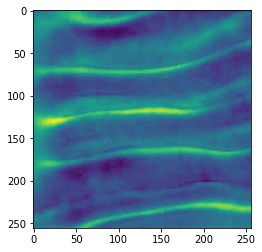

In [4]:
plt.figure()
plt.imshow(dater[0][0,0,100:356,150:406])
plt.show()

In [5]:
dat = np.stack([d[::2,0:,100:356,150:406] for d in dater],axis=1)
dat = dat.reshape([17*100,256,256,1])
dat.shape

(1700, 256, 256, 1)

In [6]:
pca = skd.PCA(n_components='mle')
pca.fit(np.random.randn(100,100))

PCA(n_components='mle')

In [7]:
pca.components_.shape[0]

1

In [8]:
class PCA_pyramid():
   def __init__(self,reduces=[],chipsizes=[],n_components=[]):
      self.reduces = reduces
      self.chipsizes = chipsizes
      self.n_components = n_components
      assert(len(reduces)==len(chipsizes))
      #assert(len(reduces)==len(n_components))
      self.n_stages = len(reduces)
      if len(self.n_components) == 0:
         self.n_components = [0,]*len(reduces)
      self.n_components.insert(0,1) #this makes thecode for reverse so much cleaner
   def fit_transform(self,vid):
      self.pcas = []
      level = 0
      for n, (reduce, chipsize, n_component) in enumerate(zip(self.reduces, self.chipsizes, self.n_components[1:])):
         print(f'Starting level {level}')
         #print([chipsize,n_component,reduce])
         vid,pcap = pca_reduce(vid,chipsize=chipsize,n_components=n_component,reduce=reduce)
         if not n_component:
            self.n_components[n+1] = pcap.components_.shape[0]
            print(self.n_components[n+1])
         self.pcas.append(copy.copy(pcap))
         level+=1
      return vid.squeeze()
   def reverse(self,state_vec):
      assert(len(state_vec.shape)==2)
      state_vec = np.expand_dims(state_vec,axis=[1,2])
      quant = state_vec.shape[0]
      current_size = np.array([1,1])
      for pca,n_component,chipsize in zip(self.pcas[-1::-1],self.n_components[-2::-1],self.chipsizes[-1::-1]):
         state_vec = state_vec@pca.components_
         current_size = current_size*chipsize
         rvid = np.zeros([quant,current_size[0],current_size[1],n_component])
         grid = product(range(0, current_size[0], chipsize), range(0, current_size[1], chipsize))
         for n,ij in enumerate(grid):
            i,j = ij 
            rvid[:,i:(i+chipsize),j:(j+chipsize)]=state_vec[:,i//chipsize,j//chipsize,:].reshape([-1,chipsize,chipsize,n_component])
         state_vec = copy.copy(rvid)
      return state_vec
         





def pca_reduce(vid, reduce=1, chipsize=8,n_components=8):
   #vid should be [framenum, x, y, c]
   x = vid.shape[1]
   y = vid.shape[2]
   c = chipsize
   if not vid.shape[1]%chipsize == 0 or\
      not vid.shape[2]%chipsize == 0:
      print('get a better chipsize!')
      return 0
   tc = (x//c)*(y//c)
   chips = np.zeros((vid.shape[0]*tc,c*c*vid.shape[3]))
   #chips = np.zeros((vid.shape[0]*tc//reduce,c*c*vid.shape[3]))
   #for f in range(0,vid.shape[0],reduce):
   for f in range(0,vid.shape[0]):
      grid = product(range(0, x-x%c, c), range(0, y-y%c, c))
      for n,ij in enumerate(grid):
         i,j = ij
         #chips[(f//reduce)*tc+n] = vid[f,i:(i+c),j:(j+c),:].flatten()
         chips[(f)*tc+n] = vid[f,i:(i+c),j:(j+c),:].flatten()
   if n_components:
      pca = skd.PCA(n_components=n_components)
   else:
      pca = skd.PCA(n_components='mle')
   if reduce > 1:
      pca.fit(chips[::reduce])
      chips = pca.transform(chips)
   else:
      chips = pca.fit_transform(chips)
   return chips.reshape((vid.shape[0],x//c,y//c,-1)), pca
   


In [18]:
chipsizes=[8,8,4]
n_components=[12,64,0]
reduces = [10,5,1]
pcap = PCA_pyramid(reduces=reduces,chipsizes=chipsizes,n_components=n_components)

In [15]:
chipsizes=[8,8,4]
n_components=[12,32,64]
reduces = [5,5,2]
pcap = PCA_pyramid(reduces=reduces,chipsizes=chipsizes,n_components=n_components)

In [19]:
daty = pcap.fit_transform(dat)

Starting level 0
Starting level 1
Starting level 2
503


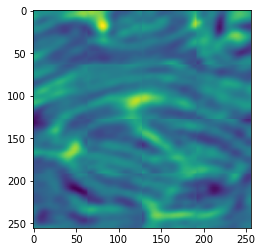

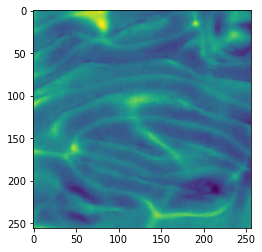

In [57]:
n = 900
r = pcap.reverse(daty[n:n+1])  #this keeps the dim
plt.figure()
plt.imshow(r.squeeze())#-dat[100].squeeze())
plt.show()
plt.figure()
plt.imshow(dat[n].squeeze())
plt.show()

In [21]:
dats = daty.reshape([100,17,-1])
filt = np.ones(10)
sdats = np.apply_along_axis(lambda m: np.convolve(m, filt, mode='full'), axis=0, arr=dats)
sdats.shape

(109, 17, 503)

In [100]:
from importlib import reload
reload(local_linear)

<module 'local_linear' from 'c:\\Users\\water\\Code\\transients\\local_linear.py'>

In [94]:
dats.shape

(100, 17, 503)

In [113]:
np.expand_dims(np.arange(numframes),axis=0).repeat(dats.shape[0],axis=0).shape

(100, 17)

In [96]:
numframes=17
ps=100

In [116]:
dats.shape

(100, 17, 503)

In [134]:
reload(local_linear)
As,frame_ass = local_linear.local_linear(dats,4,nearest=False)

[ 0.          0.73913043  1.47826087  2.2173913   2.95652174  3.69565217
  4.43478261  5.17391304  5.91304348  6.65217391  7.39130435  8.13043478
  8.86956522  9.60869565 10.34782609 11.08695652 11.82608696 12.56521739
 13.30434783 14.04347826 14.7826087  15.52173913 16.26086957 17.        ]
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17


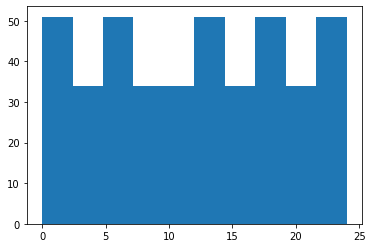

In [135]:
plt.figure()
plt.hist(frame_ass.flatten())
plt.show()

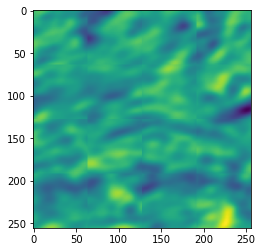

In [136]:
thing = np.zeros_like(daty[n:n+1])
thing[0,1:64] = np.abs(vv[4])
r = pcap.reverse(thing)
plt.figure()
plt.imshow(r.squeeze())#-dat[100].squeeze())
plt.show()

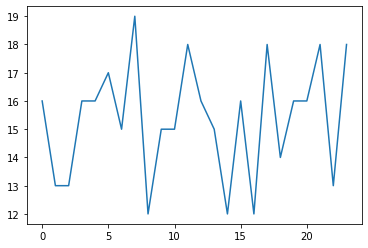

In [142]:
ne = []
mv = []
ee = []
for A in As:
    e,v = np.linalg.eig(A[1:32,1:32])
    ne.append(len(np.where(np.real(e)>0)[0]))
    ee.append(e)
    mv.append(v)
    #plt.figure()
    #plt.plot(np.sort(np.real(e)))
    #plt.title(f'{len(np.where(np.real(e)>0)[0])} Positive')
    #plt.show()
plt.figure()
plt.plot(ne)
plt.show()

In [143]:
ve = []
vv = []
thr = .25
for q in range(48):
    ve.append([])
    vv.append([])
    for m in range(15):
        for n in range(15):
            if mv[q][m].dot(mv[q+1][n]) > thr:
                print(f"keeping {q},{m}")
                vv[-1].append(mv[q][m])
                ve[-1].append(ee[q][m])

keeping 0,0
keeping 0,0
keeping 0,0
keeping 0,1
keeping 0,1
keeping 0,4
keeping 0,5
keeping 0,5
keeping 0,5
keeping 0,6
keeping 0,6
keeping 0,8
keeping 0,8
keeping 0,9
keeping 0,12
keeping 0,13
keeping 0,14
keeping 0,14
keeping 1,1
keeping 1,1
keeping 1,3
keeping 1,3
keeping 1,3
keeping 1,3
keeping 1,4
keeping 1,5
keeping 1,5
keeping 1,5
keeping 1,8
keeping 1,8
keeping 1,11
keeping 1,11
keeping 2,0
keeping 2,0
keeping 2,1
keeping 2,1
keeping 2,1
keeping 2,2
keeping 2,3
keeping 2,7
keeping 2,7
keeping 2,7
keeping 2,7
keeping 2,7
keeping 2,10
keeping 2,10
keeping 2,13
keeping 2,13
keeping 2,14
keeping 3,0
keeping 3,0
keeping 3,1
keeping 3,2
keeping 4,1
keeping 4,1
keeping 4,3
keeping 4,3
keeping 4,5
keeping 4,5
keeping 4,6
keeping 4,6
keeping 4,7
keeping 4,7
keeping 4,7
keeping 4,8
keeping 4,9
keeping 4,10
keeping 4,10
keeping 4,10
keeping 4,10
keeping 4,11
keeping 4,11
keeping 4,13
keeping 4,13
keeping 4,13
keeping 5,1
keeping 5,1
keeping 5,1
keeping 5,2
keeping 5,2
keeping 5,9
keeping 

IndexError: list index out of range

In [148]:
dater[0].shape

(200, 1, 480, 640)

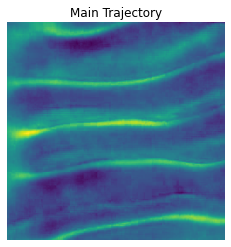

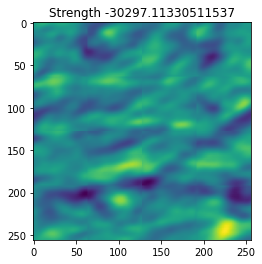

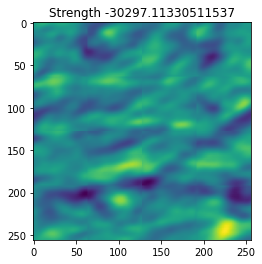

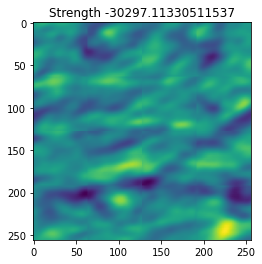

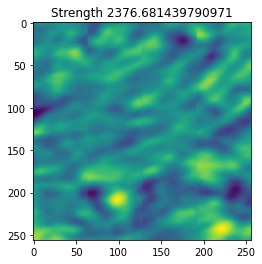

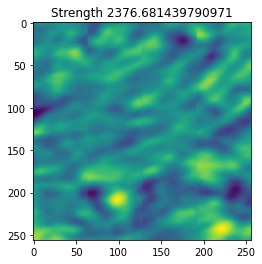

In [152]:
n = 0
plt.figure()
plt.imshow(dater[0][2*2*n,0,100:356,150:406].squeeze())
plt.title('Main Trajectory')
plt.axis('off')
plt.show()
for q in range(5):
    thing = np.zeros_like(daty[0:1])
    thing[0,1:32] = np.abs(vv[n][q])
    r = pcap.reverse(thing)
    plt.figure()
    plt.title(f'Strength {np.sign(np.real(ve[n][q]))*np.abs(ve[n][q])}')
    plt.imshow(r.squeeze())#-dat[100].squeeze())
    plt.axis('off')
    plt.show()


In [65]:
thing.shape

(2,)

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


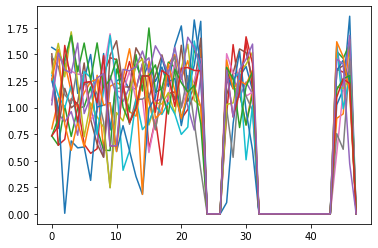

In [39]:
mv = np.stack(mv)
plt.figure()
plt.plot(np.sqrt(np.sum((mv[0:-1,:,:]-mv[1:,:,:])**2,axis=1)))
plt.show()

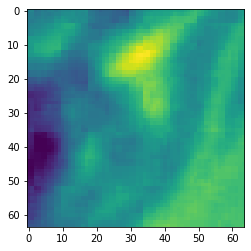

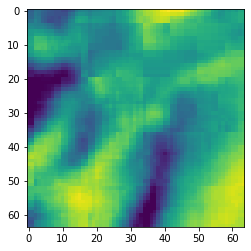

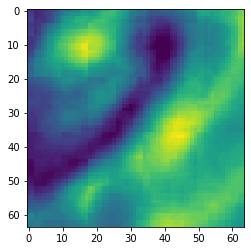

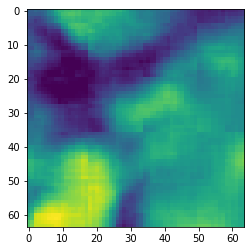

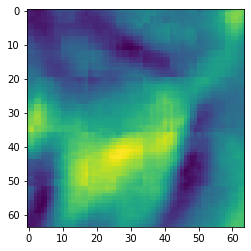

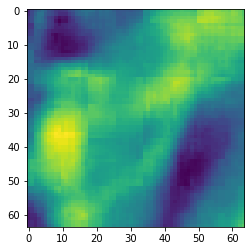

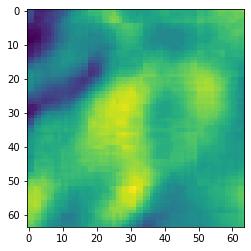

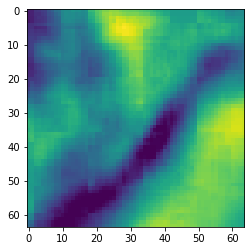

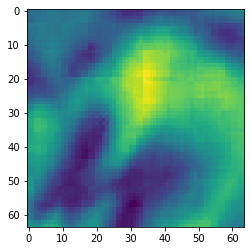

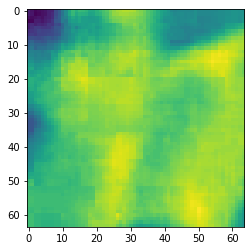

In [50]:
for q in range(0,100,10):
    plt.figure()
    plt.imshow(dat[mp+q,:,:,0])
    plt.show()

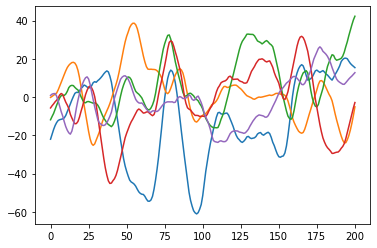

In [58]:
q=0
plt.figure()
plt.plot(svid[mq:(mq+lenny),q+0])
plt.plot(svid[mq:(mq+lenny),q+1])
plt.plot(svid[mq:(mq+lenny),q+2])
plt.plot(svid[mq:(mq+lenny),q+3])
plt.plot(svid[mq:(mq+lenny),q+4])
plt.show()

In [54]:
vid=dat
reduce=10
chipsize=8
n_components=8
x = vid.shape[1]
y = vid.shape[2]
c = chipsize
if not vid.shape[1]%chipsize == 0 or\
    not vid.shape[2]%chipsize == 0:
    print('get a better chipsize!')
tc = (x//c)*(y//c)
chips = np.zeros((vid.shape[0]*tc,c*c*vid.shape[3]))
for f in range(vid.shape[0]):
    grid = product(range(0, x-x%c, c), range(0, y-y%c, c))
    for n,ij in enumerate(grid):
        i,j = ij
        #chips[(f//reduce)*tc+n] = vid[f,i:(i+c),j:(j+c),:].flatten()
        chips[f*tc+n, :] = vid[f,i:(i+c),j:(j+c),:].flatten()
        #pdb.set_trace()
        #chips[f*tc+n,:] = copy.copy(vid[f,i:(i+c),j:(j+c),:].flatten())
chips.shape

(6558208, 64)

In [39]:
pca1.components_.shape

(12, 64)

In [48]:
128//8

16

In [45]:
np.where(np.max(chips,axis=1) == 0)[0][0]

256

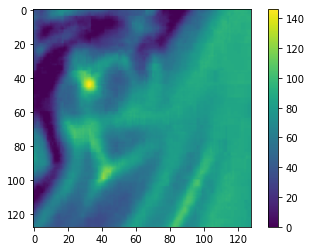

In [51]:
plt.figure()
plt.imshow(vid[50,:,:,0])
plt.colorbar()
plt.show()

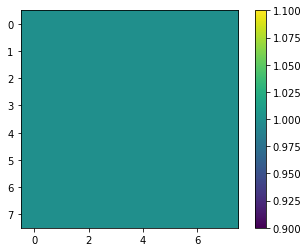

In [52]:
plt.figure()
plt.imshow(chips[16*16*50+3,:].reshape([8,8]))
plt.imshow(chips[250,:].reshape([8,8]))
plt.colorbar()
plt.show()

In [ ]:
pca = skd.PCA(n_components=n_components)
if reduce > 1:
    pca.fit(chips[::reduce])
    chips = pca.transform(chips)
else:
    chips = pca.fit_transform(chips)
chips
